In [1]:
import pandas as pd
import gc
from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, f1_score
import random 
import warnings
import transformers
import torch

warnings.filterwarnings('ignore', category=FutureWarning)
transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

2026-02-22 09:22:07.825643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-22 09:22:07.825716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-22 09:22:07.827199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-22 09:22:07.834038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda


### Load data

In [2]:
# Load as HuggingFace dataset
dataset = Dataset.from_csv('/home/zmosley/teams/z12/google_review_insights/data/cleaned_for_LLM.csv')
print(f"Loaded {len(dataset):,} rows")

# Filter out manual labeling set
absa_ids = set(pd.read_csv('/home/zmosley/teams/z12/google_review_insights/data/absa_training_set.csv', usecols=['review_id'])['review_id'].astype(str))
dataset = dataset.filter(lambda x: x['review_id'] not in absa_ids, num_proc=32)
print(f"After filtering absa set: {len(dataset):,} rows")

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Loaded 22,624,379 rows
After filtering absa set: 22,614,379 rows


***Note:*** 0% is a display bug in the notebook/library version.

## RoBERTa Tokenization

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

aspect_cols = [
             'product_quality_positive', 'product_quality_negative',
             'service_positive', 'service_negative',
             'wait_time_positive', 'wait_time_negative',
             'price_value_positive', 'price_value_negative',
             'cleanliness_positive', 'cleanliness_negative',
             'atmosphere_positive', 'atmosphere_negative',
             'general_positive', 'general_negative'
             ]

def tokenize_function(examples):
    """Tokenize text and prepare multi-label targets."""
    tokenized_dataset = tokenizer(
        examples['text'],
        padding='longest',  # only pads longest batch, not always full 128
        truncation=True,
        max_length=128     
    )
    labels = []
    for i in range(len(examples['text'])):
        label_row = [float(examples[col][i]) for col in aspect_cols]
        labels.append(label_row)
    tokenized_dataset['labels'] = labels
    return tokenized_dataset

tokenized_dataset = dataset.map(tokenize_function, 
                        batched=True, 
                        batch_size=25000,
                        num_proc=8,
                        remove_columns=dataset.column_names)
tokenized_dataset.save_to_disk('/home/zmosley/private/tokenized_for_roberta')

Map (num_proc=8):   0%|          | 0/22614379 [00:00<?, ? examples/s]

Saving the dataset (0/35 shards):   0%|          | 0/22614379 [00:00<?, ? examples/s]

In [4]:
# Clear memory
del dataset
gc.collect()

830

### Load tokenized dataset

In [2]:
# Dataset stays on disk, rows load only when needed
tokenized_dataset = load_from_disk('tokenized_for_roberta')
print(f"Loaded {len(tokenized_dataset):,} rows")

aspect_cols = [
             'product_quality_positive', 'product_quality_negative',
             'service_positive', 'service_negative',
             'wait_time_positive', 'wait_time_negative',
             'price_value_positive', 'price_value_negative',
             'cleanliness_positive', 'cleanliness_negative',
             'atmosphere_positive', 'atmosphere_negative',
             'general_positive', 'general_negative'
             ]

Loading dataset from disk:   0%|          | 0/35 [00:00<?, ?it/s]

Loaded 22,614,379 rows


### Evaluation Metrics

In [3]:
# Define metrics
def compute_metrics(pred):
    """Compute evaluation metrics for multi-label classification."""
    labels = pred.label_ids
    preds = (pred.predictions > 0.5).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# RoBERTa-base (10k Sample)

### Train

In [5]:
# Configuration for each run
SAMPLE_SIZE   = 10_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    metric_for_best_model='f1',
    logging_steps=100,
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=4,
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training on 10k...\n")
trainer.train()

Train subset: 9,000
Test subset:  1,000
Loading RoBERTa model...
Model loaded with 14 output labels

Starting training on 10k...

{'loss': 0.3528, 'grad_norm': 1.973892331123352, 'learning_rate': 1.5271867612293146e-05, 'epoch': 0.7092198581560284}
{'eval_loss': 0.23269933462142944, 'eval_accuracy': 0.417, 'eval_f1': 0.5756075724272011, 'eval_precision': 0.6107407306472006, 'eval_recall': 0.5559662090813094, 'eval_runtime': 1.2012, 'eval_samples_per_second': 832.523, 'eval_steps_per_second': 6.66, 'epoch': 1.0}
{'loss': 0.2292, 'grad_norm': 0.8337379693984985, 'learning_rate': 1.054373522458629e-05, 'epoch': 1.4184397163120568}
{'eval_loss': 0.19306804239749908, 'eval_accuracy': 0.483, 'eval_f1': 0.6225100541247023, 'eval_precision': 0.705154501940464, 'eval_recall': 0.590285110876452, 'eval_runtime': 0.7431, 'eval_samples_per_second': 1345.696, 'eval_steps_per_second': 10.766, 'epoch': 2.0}
{'loss': 0.1966, 'grad_norm': 1.0075093507766724, 'learning_rate': 5.815602836879432e-06, 'epoc

TrainOutput(global_step=423, training_loss=0.23580902068045687, metrics={'train_runtime': 51.2232, 'train_samples_per_second': 527.105, 'train_steps_per_second': 8.258, 'train_loss': 0.23580902068045687, 'epoch': 3.0})

### Evaluate

In [6]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))


RoBERTa (10,000 Sample) — Epochs: 3 | LR: 2e-05 | Batch: 64
{'eval_loss': 0.16451042890548706, 'eval_accuracy': 0.5267777777777778, 'eval_f1': 0.6824589046458536, 'eval_precision': 0.8083889836376158, 'eval_recall': 0.649075215782984, 'eval_runtime': 4.43, 'eval_samples_per_second': 2031.595, 'eval_steps_per_second': 16.027, 'epoch': 3.0}
Training Accuracy: 0.5268
{'eval_loss': 0.18253390491008759, 'eval_accuracy': 0.512, 'eval_f1': 0.6619668223246746, 'eval_precision': 0.7617299595990156, 'eval_recall': 0.6314677930306231, 'eval_runtime': 0.7241, 'eval_samples_per_second': 1380.968, 'eval_steps_per_second': 11.048, 'epoch': 3.0}
Test Accuracy:     0.5120

F1 Score (macro):    0.3592
F1 Score (weighted): 0.6620

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.87      0.84      0.85       335
product_quality_negative       0.66      0.56      0.60        70
        service_positive       0.93      0.88      0.91

In [7]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# RoBERTa-base (25k Sample)

### Train

In [8]:
# Configuration for each run
SAMPLE_SIZE   = 25_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    metric_for_best_model='f1',
    logging_steps=100,
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=4,
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training on 25k...\n")
trainer.train()

Train subset: 22,500
Test subset:  2,500
Loading RoBERTa model...
Model loaded with 14 output labels

Starting training on 25k...

{'loss': 0.3562, 'grad_norm': 0.8259798884391785, 'learning_rate': 1.810606060606061e-05, 'epoch': 0.2840909090909091}
{'loss': 0.2227, 'grad_norm': 1.7199102640151978, 'learning_rate': 1.6212121212121212e-05, 'epoch': 0.5681818181818182}
{'loss': 0.1714, 'grad_norm': 1.2460275888442993, 'learning_rate': 1.431818181818182e-05, 'epoch': 0.8522727272727273}
{'eval_loss': 0.14393724501132965, 'eval_accuracy': 0.5968, 'eval_f1': 0.7446483590480752, 'eval_precision': 0.9038654961088126, 'eval_recall': 0.6948417858690941, 'eval_runtime': 1.712, 'eval_samples_per_second': 1460.244, 'eval_steps_per_second': 11.682, 'epoch': 1.0}
{'loss': 0.1473, 'grad_norm': 2.0285773277282715, 'learning_rate': 1.2424242424242425e-05, 'epoch': 1.1363636363636362}
{'loss': 0.1282, 'grad_norm': 0.9137769341468811, 'learning_rate': 1.053030303030303e-05, 'epoch': 1.4204545454545454}
{

TrainOutput(global_step=1056, training_loss=0.1483469090678475, metrics={'train_runtime': 120.7463, 'train_samples_per_second': 559.024, 'train_steps_per_second': 8.746, 'train_loss': 0.1483469090678475, 'epoch': 3.0})

### Evaluate

In [10]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))


RoBERTa (25,000 Sample) — Epochs: 3 | LR: 2e-05 | Batch: 64
{'eval_loss': 0.07757622748613358, 'eval_accuracy': 0.8555111111111111, 'eval_f1': 0.9167509040968003, 'eval_precision': 0.9574694570306693, 'eval_recall': 0.8956098284471251, 'eval_runtime': 10.7399, 'eval_samples_per_second': 2094.984, 'eval_steps_per_second': 16.387, 'epoch': 3.0}
Training Accuracy: 0.8555
{'eval_loss': 0.09729032963514328, 'eval_accuracy': 0.8196, 'eval_f1': 0.8814882511843799, 'eval_precision': 0.9234961559263367, 'eval_recall': 0.8589076723016905, 'eval_runtime': 1.449, 'eval_samples_per_second': 1725.375, 'eval_steps_per_second': 13.803, 'epoch': 3.0}
Test Accuracy:     0.8196

F1 Score (macro):    0.7410
F1 Score (weighted): 0.8815

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.95      0.93      0.94       794
product_quality_negative       0.80      0.70      0.74       220
        service_positive       0.96      0.93      

### Clear memory

In [11]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# RoBERTa-base (50k Sample)

### Train

In [4]:
# Configuration for each run
SAMPLE_SIZE   = 50_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    metric_for_best_model='f1',
    logging_steps=100,
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=8,
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training on 25k...\n")
trainer.train()

Train subset: 45,000
Test subset:  5,000
Loading RoBERTa model...
Model loaded with 14 output labels

Starting training on 25k...

{'loss': 0.3568, 'grad_norm': 0.995448648929596, 'learning_rate': 1.9053030303030303e-05, 'epoch': 0.14204545454545456}
{'loss': 0.2265, 'grad_norm': 1.5018106698989868, 'learning_rate': 1.810606060606061e-05, 'epoch': 0.2840909090909091}
{'loss': 0.1864, 'grad_norm': 0.8371774554252625, 'learning_rate': 1.715909090909091e-05, 'epoch': 0.42613636363636365}
{'loss': 0.1539, 'grad_norm': 0.8371503949165344, 'learning_rate': 1.6212121212121212e-05, 'epoch': 0.5681818181818182}
{'loss': 0.1352, 'grad_norm': 2.050896644592285, 'learning_rate': 1.5265151515151517e-05, 'epoch': 0.7102272727272727}
{'loss': 0.1143, 'grad_norm': 0.9707364439964294, 'learning_rate': 1.431818181818182e-05, 'epoch': 0.8522727272727273}
{'loss': 0.103, 'grad_norm': 0.926863968372345, 'learning_rate': 1.3371212121212122e-05, 'epoch': 0.9943181818181818}
{'eval_loss': 0.09242776036262512,

TrainOutput(global_step=2112, training_loss=0.10903243105294126, metrics={'train_runtime': 241.066, 'train_samples_per_second': 560.013, 'train_steps_per_second': 8.761, 'train_loss': 0.10903243105294126, 'epoch': 3.0})

### Evaluate

In [5]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))


RoBERTa (50,000 Sample) — Epochs: 3 | LR: 2e-05 | Batch: 64
{'eval_loss': 0.0544128455221653, 'eval_accuracy': 0.9107111111111111, 'eval_f1': 0.9442239908479917, 'eval_precision': 0.9623295779019047, 'eval_recall': 0.9294424551170832, 'eval_runtime': 21.2458, 'eval_samples_per_second': 2118.063, 'eval_steps_per_second': 16.568, 'epoch': 3.0}
Training Accuracy: 0.9107
{'eval_loss': 0.06969144195318222, 'eval_accuracy': 0.8846, 'eval_f1': 0.9150037522607003, 'eval_precision': 0.9367165662955027, 'eval_recall': 0.8984126984126984, 'eval_runtime': 2.7313, 'eval_samples_per_second': 1830.606, 'eval_steps_per_second': 14.645, 'epoch': 3.0}
Test Accuracy:     0.8846

F1 Score (macro):    0.8470
F1 Score (weighted): 0.9150

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.95      0.95      0.95      1509
product_quality_negative       0.88      0.74      0.80       392
        service_positive       0.96      0.95      

In [6]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# RoBERTa-base (100k Sample)

### Train

In [7]:
# Configuration for each run
SAMPLE_SIZE   = 100_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    metric_for_best_model='f1',
    logging_steps=100,
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=8,
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training on 25k...\n")
trainer.train()

Train subset: 90,000
Test subset:  10,000
Loading RoBERTa model...
Model loaded with 14 output labels

Starting training on 25k...

{'loss': 0.3616, 'grad_norm': 1.3781739473342896, 'learning_rate': 1.9526178630656246e-05, 'epoch': 0.07107320540156362}
{'loss': 0.2214, 'grad_norm': 1.333020567893982, 'learning_rate': 1.9052357261312486e-05, 'epoch': 0.14214641080312723}
{'loss': 0.1702, 'grad_norm': 0.9893063902854919, 'learning_rate': 1.857853589196873e-05, 'epoch': 0.21321961620469082}
{'loss': 0.1376, 'grad_norm': 1.228359580039978, 'learning_rate': 1.810471452262497e-05, 'epoch': 0.28429282160625446}
{'loss': 0.1182, 'grad_norm': 0.8681268095970154, 'learning_rate': 1.7630893153281215e-05, 'epoch': 0.35536602700781805}
{'loss': 0.1091, 'grad_norm': 2.3045566082000732, 'learning_rate': 1.715707178393746e-05, 'epoch': 0.42643923240938164}
{'loss': 0.0971, 'grad_norm': 1.1308273077011108, 'learning_rate': 1.66832504145937e-05, 'epoch': 0.4975124378109453}
{'loss': 0.0895, 'grad_norm':

TrainOutput(global_step=4221, training_loss=0.07853319248975778, metrics={'train_runtime': 475.9689, 'train_samples_per_second': 567.264, 'train_steps_per_second': 8.868, 'train_loss': 0.07853319248975778, 'epoch': 3.0})

### Evaluate

In [8]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))


RoBERTa (100,000 Sample) — Epochs: 3 | LR: 2e-05 | Batch: 64
{'eval_loss': 0.040743716061115265, 'eval_accuracy': 0.9358111111111111, 'eval_f1': 0.954720032787958, 'eval_precision': 0.9664705405776112, 'eval_recall': 0.9445979961502394, 'eval_runtime': 42.1879, 'eval_samples_per_second': 2133.312, 'eval_steps_per_second': 16.687, 'epoch': 3.0}
Training Accuracy: 0.9358
{'eval_loss': 0.055802833288908005, 'eval_accuracy': 0.9148, 'eval_f1': 0.9302218380130469, 'eval_precision': 0.9436478497008447, 'eval_recall': 0.9191711571579356, 'eval_runtime': 5.1176, 'eval_samples_per_second': 1954.042, 'eval_steps_per_second': 15.437, 'epoch': 3.0}
Test Accuracy:     0.9148

F1 Score (macro):    0.8789
F1 Score (weighted): 0.9302

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.96      0.96      0.96      3117
product_quality_negative       0.89      0.78      0.83       771
        service_positive       0.96      0.97   

In [9]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# RoBERTa-base (250k Sample)

### Train

In [10]:
# Configuration for each run
SAMPLE_SIZE   = 250_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=16,
    optim="adamw_torch_fused",
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training...\n")
trainer.train()

Train subset: 225,000
Test subset:  25,000
Loading RoBERTa model...
Model loaded with 14 output labels

Starting training on 25k...

{'loss': 0.0859, 'grad_norm': 1.0454732179641724, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.051226336508989334, 'eval_accuracy': 0.91152, 'eval_f1': 0.9291267322562651, 'eval_precision': 0.9489497858290743, 'eval_recall': 0.9137651732019617, 'eval_runtime': 51.8614, 'eval_samples_per_second': 482.054, 'eval_steps_per_second': 3.779, 'epoch': 1.0}
{'loss': 0.0479, 'grad_norm': 1.8974601030349731, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.048329152166843414, 'eval_accuracy': 0.92212, 'eval_f1': 0.935294154604637, 'eval_precision': 0.9491608283806725, 'eval_recall': 0.9247054124226084, 'eval_runtime': 72.6121, 'eval_samples_per_second': 344.295, 'eval_steps_per_second': 2.699, 'epoch': 2.0}
{'loss': 0.04, 'grad_norm': 1.4060418605804443, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.0483538731932

TrainOutput(global_step=10548, training_loss=0.057895838332800056, metrics={'train_runtime': 1542.3705, 'train_samples_per_second': 437.638, 'train_steps_per_second': 6.839, 'train_loss': 0.057895838332800056, 'epoch': 3.0})

### Evaluate

In [11]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))


RoBERTa (250,000 Sample) — Epochs: 3 | LR: 2e-05 | Batch: 64
{'eval_loss': 0.033284589648246765, 'eval_accuracy': 0.9420577777777778, 'eval_f1': 0.9578326647891511, 'eval_precision': 0.9695136682224469, 'eval_recall': 0.9479566071261573, 'eval_runtime': 285.3522, 'eval_samples_per_second': 788.499, 'eval_steps_per_second': 6.161, 'epoch': 3.0}
Training Accuracy: 0.9421
{'eval_loss': 0.04835387319326401, 'eval_accuracy': 0.92452, 'eval_f1': 0.9364575382498825, 'eval_precision': 0.9493583640996716, 'eval_recall': 0.9260590728535606, 'eval_runtime': 27.5848, 'eval_samples_per_second': 906.295, 'eval_steps_per_second': 7.105, 'epoch': 3.0}
Test Accuracy:     0.9245

F1 Score (macro):    0.8841
F1 Score (weighted): 0.9365

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.97      0.96      0.96      7731
product_quality_negative       0.90      0.81      0.85      1865
        service_positive       0.97      0.97    

In [12]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# RoBERTa-base (500k Sample)

### Train

In [ ]:
# Configuration for each run
SAMPLE_SIZE   = 500_000
TEST_SIZE     = 0.1
EPOCHS        = 3
TRAIN_BATCH   = 64
EVAL_BATCH    = 128
LEARNING_RATE = 2e-5
SEED          = 2
BALANCE_CLASSES = None
CLASS_WEIGHTS = None

# Sample & Split
random.seed(SEED)
sample       = tokenized_dataset.select(random.sample(range(len(tokenized_dataset)), SAMPLE_SIZE))
split        = sample.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_subset = split['train']
test_subset  = split['test']

print(f"Train subset: {len(train_subset):,}")
print(f"Test subset:  {len(test_subset):,}")

# Load RoBERTa-base Model 
print("Loading RoBERTa model...")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(aspect_cols),
    problem_type="multi_label_classification"
)
print(f"Model loaded with {len(aspect_cols)} output labels\n")

# Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results_roberta_{SAMPLE_SIZE}',
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=torch.cuda.is_available(),
    dataloader_num_workers=16,
    optim="adamw_torch_fused",
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics,
)
print("Starting training...\n")
trainer.train()

### Evaluate

In [ ]:
predictions = trainer.predict(test_subset)
y_pred = (predictions.predictions > 0.5).astype(int)
y_true = predictions.label_ids

print(f"\nRoBERTa ({SAMPLE_SIZE:,} Sample) — Epochs: {EPOCHS} | LR: {LEARNING_RATE} | Batch: {TRAIN_BATCH}")
print(f"Training Accuracy: {trainer.evaluate(train_subset)['eval_accuracy']:.4f}")
print(f"Test Accuracy:     {trainer.evaluate(test_subset)['eval_accuracy']:.4f}")

print(f"\nF1 Score (macro):    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=aspect_cols, zero_division=0))

In [ ]:
# Clear memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

## Comparison Charts

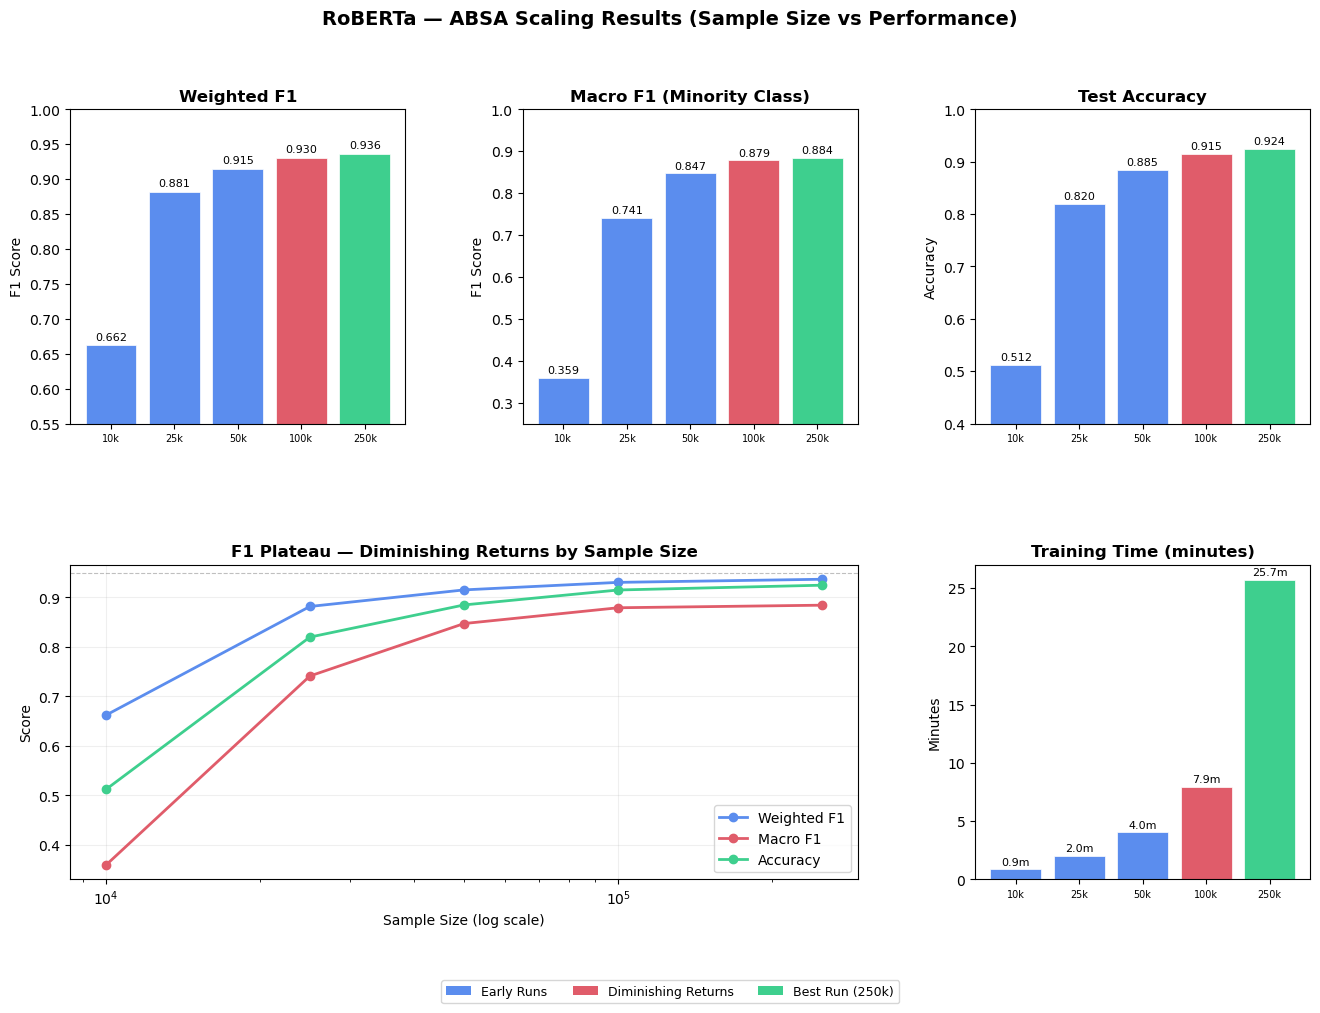

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Data
runs = ['10k', '25k', '50k', '100k', '250k']
weighted_f1  = [0.6620, 0.8815, 0.9150, 0.9302, 0.9365]
macro_f1     = [0.3592, 0.7410, 0.8470, 0.8789, 0.8841]
accuracy     = [0.5120, 0.8196, 0.8846, 0.9148, 0.9245]
train_time   = [51.2, 120.7, 241.1, 476.0, 1542.4]  # seconds

colors = ['#5b8dee', '#5b8dee', '#5b8dee', '#e05c6a', '#3ecf8e']

fig = plt.figure(figsize=(16, 10))
fig.suptitle('RoBERTa — ABSA Scaling Results (Sample Size vs Performance)', fontsize=14, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

# 1 - Weighted F1
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(runs, weighted_f1, color=colors, edgecolor='white', linewidth=0.5)
ax1.set_ylim(0.55, 1.0)
ax1.set_title('Weighted F1', fontweight='bold')
ax1.set_ylabel('F1 Score')
for bar, val in zip(bars, weighted_f1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax1.tick_params(axis='x', labelsize=7)

# 2 - Macro F1
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(runs, macro_f1, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_ylim(0.25, 1.0)
ax2.set_title('Macro F1 (Minority Class)', fontweight='bold')
ax2.set_ylabel('F1 Score')
for bar, val in zip(bars, macro_f1):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax2.tick_params(axis='x', labelsize=7)

# 3 - Accuracy
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(runs, accuracy, color=colors, edgecolor='white', linewidth=0.5)
ax3.set_ylim(0.40, 1.0)
ax3.set_title('Test Accuracy', fontweight='bold')
ax3.set_ylabel('Accuracy')
for bar, val in zip(bars, accuracy):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax3.tick_params(axis='x', labelsize=7)

# 4 - F1 Plateau line chart
ax4 = fig.add_subplot(gs[1, :2])
sample_sizes = [10000, 25000, 50000, 100000, 250000]
ax4.plot(sample_sizes, weighted_f1, color='#5b8dee', marker='o', linewidth=2, label='Weighted F1')
ax4.plot(sample_sizes, macro_f1,    color='#e05c6a', marker='o', linewidth=2, label='Macro F1')
ax4.plot(sample_sizes, accuracy,    color='#3ecf8e', marker='o', linewidth=2, label='Accuracy')
ax4.set_xscale('log')
ax4.set_xlabel('Sample Size (log scale)')
ax4.set_ylabel('Score')
ax4.set_title('F1 Plateau — Diminishing Returns by Sample Size', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.2)
ax4.axhline(0.95, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# 5 - Training time
ax5 = fig.add_subplot(gs[1, 2])
bars = ax5.bar(runs, [t/60 for t in train_time], color=colors, edgecolor='white', linewidth=0.5)
ax5.set_title('Training Time (minutes)', fontweight='bold')
ax5.set_ylabel('Minutes')
for bar, val in zip(bars, train_time):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val/60:.1f}m', ha='center', va='bottom', fontsize=8)
ax5.tick_params(axis='x', labelsize=7)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#5b8dee', label='Early Runs'),
                   Patch(facecolor='#e05c6a', label='Diminishing Returns'),
                   Patch(facecolor='#3ecf8e', label='Best Run (250k)')]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=9, bbox_to_anchor=(0.5, -0.02))

plt.savefig('../charts/roberta_scaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()